In [1]:
import mdtraj as md 
import numpy as np 
import os, sys 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

In [2]:
def source_module(module_file: str, local_module_name: str = None):
    import importlib
    """to add a module from a user defined python script into the local name space"""
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))
    g = globals()
    g[local_module_name] = module
    pass

# importing a python script where I keep a lot of the basic functions I use!
source_module("/Users/anjalidhar/Desktop/Packages/mdtools.py")
source_module("/Users/anjalidhar/Desktop/Packages/Writhe_Package/package/visualize/visualize.py")

from visualize import palettes

In [3]:
# this is just wrong
# assumes gaussian, which we really don't have!
def std_err(arr): 
    return np.std(arr) / np.sqrt(len(arr))

visualize.plot_structure(visualize.make_structures(trj,
                                                   indices=[1,2],
                                                   dir="./images",
                                                   ensemble=True,
                                                   overwrite=True,
                                                   ref=pdb,
                                                   transparency=.6,
                                                   draw_style="cartoon",
                                                   name="test",
                                                   palette = palettes['coolwarm'],
                                                   save_state=True,
                                                   cartoon_loop_radius=.35,
                                                   beta_values=np.random.rand(20)),
                                                   legend=True, cbar=True, cbar_label="lets go",
                                                   vmin=0 , vmax=1)

## New, Autodock/GNINA scores for every residue ##

In [4]:
# autodock
adscores = {}
score_dir = '/Users/anjalidhar/Desktop/autodock/scores'
runs = ['41on41bf', '47on47bf', '41onapo', '47onapo']
for run in runs: 
    adscores[run] = np.load(f'{score_dir}/{run}.npy')


## Getting score std errors ##

In [13]:
def std_err(arr): 
    return np.std(arr) / np.sqrt(len(arr))

In [14]:
std_errs = {}

In [15]:
runs = ['41on41bf', '47on47bf', '41onapo', '47onapo']
for run in runs: 
    std_errs[run] = np.stack( [ np.apply_along_axis(std_err, axis=0, arr=x) for x in adscores[run] ])

## Tommy's Figures ##

/var/folders/s0/8tkldvk957j2fw0m74_wyykw0000gn/T/ipykernel_60498/1753789294.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


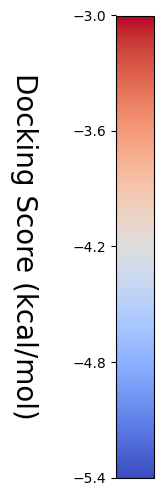

In [44]:


dmin = -5.4
dmax = -3.0
cmap = cm.coolwarm

# Create a ScalarMappable object to associate the color map with the color range
norm = plt.Normalize(vmin=dmin, vmax=dmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Create a figure just for the color bar
fig, ax = plt.subplots(figsize=(.5, 6))  # Adjust the width and height of the color bar
cb = ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', ticks=np.linspace(dmin, dmax, 5))  # Add numerical labels

# Set label for the color bar and align it to the left
cb.set_label('Docking Score (kcal/mol)', fontsize=20, rotation=270) #, labelpad=1) #, ha='left')

# Manually adjust label position
cb.ax.yaxis.set_label_coords(-2, 0.5)
cb.ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()

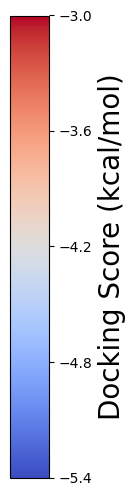

In [43]:
dmin = -5.4
dmax = -3.0
cmap = cm.coolwarm

# Create a ScalarMappable object to associate the color map with the color range
norm = plt.Normalize(vmin=dmin, vmax=dmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Create a figure just for the color bar
fig, ax = plt.subplots(figsize=(.5, 6))  # Adjust the width and height of the color bar
cb = ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', ticks=np.linspace(dmin, dmax, 5))  # Add numerical labels

# Set label for the color bar
cb.set_label('Docking Score (kcal/mol)', fontsize=20)

plt.show()

In [16]:
def get_color_list(n_colors: int, cmap: str, trunc=0, pre_trunc=0):
    cmap = getattr(plt.cm, cmap)
    cl = [cmap(i) for i in range(cmap.N)]
    return [cl[i] for i in np.linspace(1 + pre_trunc, len(cl) - 1 - trunc, n_colors).astype(int)]

In [77]:
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Create a truncated version of the colormap."""
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_color_list(values: np.ndarray, cmap: str, trunc=0, pre_trunc=0, reverse: bool = False):
    norm = plt.Normalize(values.min(), values.max())
    cmap = plt.get_cmap(cmap)
    
    if reverse:
        cmap = cmap.reversed()
    cmap = truncate_colormap(cmap, pre_trunc, trunc)
    return cmap(norm(values))

def box_plot(values: np.ndarray,
             errors: np.ndarray = None,
             labels: np.ndarray = None,
             ylabel: str = None,
             xlabel: str = None,
             ymin: float = None,
             ymax: float = None,
             cmap: str = "viridis",
             title: str = "Stationary Distribution",
             ax=None,
             font_scale: float = 5,
             label_stride: int = 1,
             capsize: float = 10,
             width: float = .9,
             linewidth: float = 1,
             edgecolor: str = "black", 
             alpha: float = 1,
             trunc: int = 25,
             pre_trunc: int = 25,
             rotation: float = 0):
    
    # make the stationary valuesribution and it's error 1D vectors
    # (assuming abs(upper) and abs(lower) errors have been averaged):

    values, errors = [i.squeeze() if i is not None else None for i in [values, errors]]

    assert len(values.shape) == 1, \
        "Need a stationary distribution that can be squeezed to one dimension"

    nstates = len(values)
    print(nstates)
    labels = np.arange(1, nstates + 1) if labels is None else labels
    
    assert len(labels) == nstates, "Length of values and labels must be the same"

    clist = get_color_list(values, cmap, trunc, pre_trunc, reverse=True )
    print(clist)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(13, 2.5))

    ax.bar(labels, values, yerr=errors,
           ecolor="grey", color=clist, capsize=10,
           width=width, linewidth=linewidth, edgecolor=edgecolor,
           align="center", alpha=alpha,  error_kw=dict(capthick=3, lw=3),
           )

    ax.set_xticks(np.arange(0, nstates)-1)
    ax.set_xticklabels(labels, rotation=rotation)
    ax.set_xlabel(xlabel, size=7 * font_scale)
    ax.set_ylabel(ylabel, size=7 * font_scale)
    ax.set_title(title, size=8 * font_scale)
    
    if all(i is not None for i in (ymin, ymax)):
        ax.set_ylim(ymin, ymax)
    
    ax.tick_params("both", labelsize=6 * font_scale)
    #ax.set_xlim(0, nstates )

In [18]:
from matplotlib.lines import Line2D
full_res_seq = ['ASP121','ASN122','GLU123',
 'ALA124','TYR125','GLU126','MET127','PRO128','SER129','GLU130',
 'GLU131','GLY132','TYR133','GLN134','ASP135','TYR136','GLU137','PRO138','GLU139','ALA140']

20
[[0.2298057  0.29871797 0.75368315 1.        ]
 [0.27488256 0.36537566 0.81146137 1.        ]
 [0.41821525 0.55069202 0.9410396  1.        ]
 [0.82031125 0.8561802  0.91250474 1.        ]
 [0.94968142 0.7896352  0.70907709 1.        ]
 [0.82031125 0.8561802  0.91250474 1.        ]
 [0.71777258 0.81097109 0.97757202 1.        ]
 [0.77206493 0.83853205 0.94944007 1.        ]
 [0.64270985 0.76186319 0.99714245 1.        ]
 [0.59231063 0.72236045 0.99873014 1.        ]
 [0.7256343  0.81553004 0.97449364 1.        ]
 [0.95860454 0.76789556 0.67598291 1.        ]
 [0.75641121 0.1633308  0.18755727 1.        ]
 [0.79258121 0.23476793 0.2186947  1.        ]
 [0.93439278 0.52615864 0.41249142 1.        ]
 [0.70567316 0.01555616 0.15023281 1.        ]
 [0.96961541 0.69216019 0.5771776  1.        ]
 [0.8285787  0.85834544 0.90468418 1.        ]
 [0.4950191  0.63340952 0.97913016 1.        ]
 [0.2298057  0.29871797 0.75368315 1.        ]]


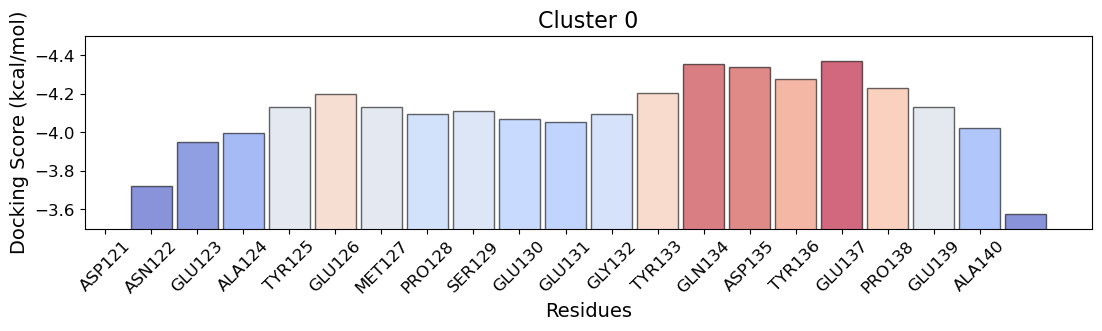

In [78]:
run = '47onapo'
c_idx = 0 
scores = adscores[run].mean(1)[c_idx]
cmap = 'coolwarm'

box_plot(scores, alpha=0.6, label_stride=3, cmap=cmap,
        font_scale=2,  ymin=-3.5, ymax=-4.5, trunc=1.8, pre_trunc=0, 
        title=f'Cluster {c_idx}', labels=full_res_seq, rotation=45, ylabel='Docking Score (kcal/mol)', 
        xlabel='Residues')
plt.savefig(f'/Users/anjalidhar/Desktop/47onapo_0.png', dpi=300, bbox_inches='tight')